In [242]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import wfdb
import glob
import random
import warnings
import tempfile
import shutil
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import butter, filtfilt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.losses import BinaryCrossentropy # type: ignore
from tensorflow.keras.metrics import BinaryAccuracy # type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint # type: ignore

FOLDER_PATH = '24h-emgcg/'
FOLDER_SAMPLE = '24h-ecg-sample/'
FOLDER_NORMALIZE = '24h-ecg-normalized/'
FOLDER_FILTER = '24h-ecg-normalized-filter/'
DATASET_QC = "dataset-qc-model/"
MODEL = "model/"
PHYSIONET_PATH = 'cves/1.0.0/data/24h-electromyography'
PHYSIONET_DIR = 'cves'

# CONVERT TO p_signal FILES USING 2 CHANNEL ecg_0 vs ecg_1

In [57]:

record_files = [f for f in os.listdir(FOLDER_PATH) if f.endswith('.hea')]

records_missing_dat = []

records_exist = []

records_header_error = []

for record_file in record_files:
    record_name = os.path.splitext(record_file)[0]
    if not os.path.exists(os.path.join(FOLDER_PATH, f"{record_name}.dat")):
        records_missing_dat.append(record_name)
        continue  
    
    output_file_path = os.path.join(FOLDER_PATH, f"{record_name}_p_signal.txt")
    
    if os.path.exists(output_file_path):
        records_exist.append(record_file)
        continue  
    
    try:
        record = wfdb.rdrecord(os.path.join(FOLDER_PATH, record_name), channels=[0, 1])
    except Exception as e:
        if isinstance(e, FileNotFoundError):
            records_missing_dat.append(record_name)
        else:
            print(f"Error processing {record_name}: {str(e)}")
            records_header_error.append(record_name)
        continue
    
    signals = record.p_signal
    
    with open(output_file_path, 'w') as file:
        for signal in signals:
            file.write(f"{signal[0]}\t{signal[1]}\n")

print("Conversion completed.")
if records_missing_dat:
    print("The following records were skipped due to missing .dat files:")
    print(records_missing_dat)
if records_header_error:
    print("The following records had header syntax errors:")
    print(records_header_error)
print(f"Number of records converted: {len(record_files) - len(records_missing_dat) - len(records_header_error)}")

Conversion completed.
Number of records converted: 0


# DELETE ALL .dat .hea .maker files

In [58]:

extensions = ['.dat', '.hea', '.marker']

def delete_files_if_txt_exists(folder_path):
    for ext in extensions:
        file_pattern = os.path.join(folder_path, f'*{ext}')
        files = glob.glob(file_pattern)
        for file_path in files:
            base_name = os.path.splitext(os.path.basename(file_path))[0]
            txt_file_path = os.path.join(folder_path, f'{base_name}_p_signal.txt')
            if os.path.exists(txt_file_path):
                try:
                    os.remove(file_path)
                    print(f"Deleted: {file_path}")
                except OSError as e:
                    print(f"Error: {file_path} - {e.strerror}")

delete_files_if_txt_exists(FOLDER_PATH)

# CONVERT BY CALL PHYSIONET

In [6]:

os.makedirs(FOLDER_PATH, exist_ok=True)

for record_name in record_files:
    # Define the path for the expected .p_signal output file
    output_file_path = os.path.join(FOLDER_PATH, f"{record_name}_p_signal.txt")
    
    # Check if the .p_signal file already exists
    if os.path.exists(output_file_path):
        print(f"File {output_file_path} already exists. Skipping...")
        continue

    # Read the specified channels (0 and 1) from the record directly from PhysioNet
    # Note: This step requires an internet connection and access permissions to the data
    record = wfdb.rdrecord(record_name, pn_dir=PHYSIONET_PATH, channels=[0, 1])

    # Extract the signals for channels 0 and 1
    signals = record.p_signal

    # Write the signals to the output file
    with open(output_file_path, 'w') as file:
        for signal in signals:
            # Write each signal sample to the file, separated by a tab
            file.write(f"{signal[0]}\t{signal[1]}\n")

print("Conversion completed. Check the local directory for the .p_signal files.")


File 24h-emgcg/s0030-04051907_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0030-04051908_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0044-05062806_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0044-05062807_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0064-05081805_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0064-05081806_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0067-05040508_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0067-05040509_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0067-05040510_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0067-05040511_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0068-05022417_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0068-05022418_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0121-04042801_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0121-04042802_p_signal.txt already exists. Skipping...
File 2

# CONVERT SIGNAL FROM uV to mV 

In [3]:

for filename in os.listdir(FOLDER_PATH):
    file_path = os.path.join(FOLDER_PATH, filename)
    if os.path.isfile(file_path):
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as temp_file:
            with open(file_path, 'r') as file:
                for line in file:
                    values = line.split()
                    modified_values = [str(float(value)/1000) for value in values]
                    temp_file.write('\t'.join(modified_values) + '\n')

        shutil.copy(temp_file.name, file_path)
        os.remove(temp_file.name)

print("All files have been modified.")


All files have been modified.


# Function get list of file names, plot data in range,...

In [210]:

# List file names from folder name
def get_main_names_of_files(x):
    file_names = os.listdir(x)
    main_names = [name.split('_p_signal.txt')[0] for name in file_names if name.endswith('_p_signal.txt')]
    return main_names

# PLOT SIGNAL IN RANGE(m , n) BY FILENAME
def plot_ecg_signal(main_name_of_file, folder_path, n, m=0):
    # start m end n
    file_path = os.path.join(folder_path, f'{main_name_of_file}_p_signal.txt')
    
    if not os.path.exists(file_path):
        print(f'File {file_path} does not exist.')
        return
    
    try:
        # Load the data with a maximum of n rows
        warnings.filterwarnings("ignore", message="Input line contained no data")
        total_data = np.loadtxt(file_path, max_rows=n)
        total_rows = total_data.shape[0]
        
        if m < 0 or n > total_rows or m >= n:
            raise ValueError(f"Invalid range: {m} to {n}. File contains {total_rows} rows.")
        
        data_segment = total_data[m:n, :]
        
    except Exception as e:
        print(f"Error reading the file: {e}")
        return
    
    time = np.arange(m, n) * 1  # 1 ms per sample
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(time, data_segment[:, 0])
    plt.title('Channel 1')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (mV)')
    
    plt.subplot(2, 1, 2)
    plt.plot(time, data_segment[:, 1])
    plt.title('Channel 2')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (mV)')
    
    plt.tight_layout()
    plt.show()

def count_rows_in_file(prefix, directory):
    suffix = '_p_signal.txt'
    filename = prefix + suffix
    file_path = os.path.join(directory, filename)
    
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
            return len(lines)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

names = get_main_names_of_files(FOLDER_PATH)

print("Main names of files:", names)
print(len(names))


Main names of files: ['s0322-07052204', 's0242-06012405', 's0184-05091311', 's0335-07040503', 's0231-05111709', 's0175-05030325', 's0376-07091805', 's0221-06082208', 's0208-05102508', 's0153-05021018', 's0225-06022111', 's0218-05110113', 's0351-07062105', 's0230-06013111', 's0197-05060906', 's0358-07071203', 's0358-07071204', 's0247-06050205', 's0376-07091804', 's0221-06082209', 's0208-05102509', 's0184-05091310', 's0239-06012607', 's0164-06033006', 's0157-05062311', 's0322-07052205', 's0231-05111708', 's0232-06060108', 's0204-05092907', 's0230-06013110', 's0351-07062104', 's0354-07051506', 's0187-05040711', 's0164-06033107', 's0218-05110112', 's0331-07031501', 's0210-05092012', 's0153-05021019', 's0030-04051907', 's0132-04102801', 's0207-05090814', 's0215-06030712', 's0305-06113004', 's0361-07080906', 's0166-05031008', 's0352-07060705', 's0305-06113003', 's0214-05110807', 's0352-07060702', 's0154-05050307', 's0160-04052807', 's0174-05062113', 's0336-07041701', 's0348-07052402', 's0221

# RAMDOMLY SAMPLE 100 NON-OVERLAPPING SEGMENTS EACH SIGNAL 

In [29]:
sampling_rate = 1000  # Freq definition
segment_length_ms = 6000
segment_length_samples = int(sampling_rate * (segment_length_ms / 1000))

max_segments = 100

for filename in os.listdir(FOLDER_PATH):
    if filename.endswith('.txt') and 'p_signal' in filename:
        file_path = os.path.join(FOLDER_PATH, filename)
        output_base_filename = filename.replace('_p_signal.txt', '')

        with open(file_path, 'r') as file:
            data = file.readlines()

        # Maximum number of segments possible
        possible_segments = min(max_segments, len(data) // segment_length_samples)

        # Calculate start points for each segment
        start_indices = sorted(random.sample(range(0, len(data) - segment_length_samples + 1), possible_segments))

        for i, start in enumerate(start_indices):
            segment = data[start:start + int(segment_length_samples)]
            segment_filename = f"{output_base_filename}_{i + 1}_p_signal.txt"
            segment_file_path = os.path.join(FOLDER_SAMPLE, segment_filename)

            with open(segment_file_path, 'w') as outfile:
                outfile.writelines(segment)

        print(f"Processed {filename} into {possible_segments} segments.")

print("Sampling complete.")

Processed s0322-07052204_p_signal.txt into 100 segments.
Processed s0242-06012405_p_signal.txt into 100 segments.
Processed s0184-05091311_p_signal.txt into 100 segments.
Processed s0335-07040503_p_signal.txt into 100 segments.
Processed s0231-05111709_p_signal.txt into 100 segments.
Processed s0175-05030325_p_signal.txt into 100 segments.
Processed s0376-07091805_p_signal.txt into 100 segments.
Processed s0221-06082208_p_signal.txt into 2 segments.
Processed s0208-05102508_p_signal.txt into 100 segments.
Processed s0153-05021018_p_signal.txt into 100 segments.
Processed s0225-06022111_p_signal.txt into 100 segments.
Processed s0218-05110113_p_signal.txt into 100 segments.
Processed s0351-07062105_p_signal.txt into 100 segments.
Processed s0230-06013111_p_signal.txt into 100 segments.
Processed s0197-05060906_p_signal.txt into 100 segments.
Processed s0358-07071203_p_signal.txt into 100 segments.
Processed s0358-07071204_p_signal.txt into 100 segments.
Processed s0247-06050205_p_signal

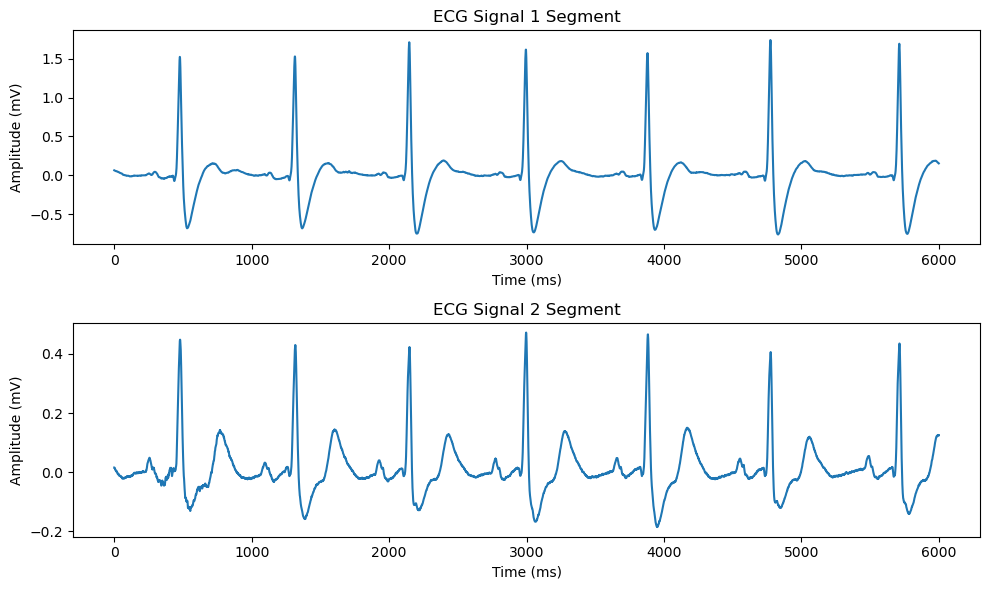

In [64]:
# CHECK DATA BY PLOT SIGNAL

# plot_ecg_signal('s0402', FOLDER_SAMPLE, 40000, 34000)
plot_ecg_signal('s0402-08010704_1', FOLDER_SAMPLE, 6000)
# plot_ecg_signal('s0402-08010704', FOLDER_PATH, 50000000)

# Normalizing datas after sampling

In [33]:
source_directory = FOLDER_SAMPLE # Replace with your actual path
destination_directory = FOLDER_NORMALIZE

scaler = MinMaxScaler()

# Process each file in the source directory
for filename in os.listdir(source_directory):
    if filename.endswith('.txt'):
        file_path = os.path.join(source_directory, filename)
        
        # Load the data from the file
        data = np.loadtxt(file_path)

        # Check if the data is in two columns or a single column
        if data.ndim == 1:
            # If it's a single column, reshape it for the scaler
            data = data.reshape(-1, 1)

        # Apply the MinMaxScaler to the data
        normalized_data = scaler.fit_transform(data)
        
        # Save the normalized data to a new file in the destination folder
        dest_file_path = os.path.join(destination_directory, filename)
        np.savetxt(dest_file_path, normalized_data)

print("All files have been normalized.")

All files have been normalized.


# Smoothing datas after normalization by ButterWorth filter

In [77]:
# Get data from 2 column of data for ploting
def extract_columns(file_name):
    full_file_path = os.path.join(FOLDER_NORMALIZE, file_name)
    
    data = np.loadtxt(full_file_path)
    
    left = data[:, 0]
    right = data[:, 1]    
    return left, right

# Function to apply the low-pass filter
def butterworth_filter(signal):
    cutoff_frequency = 11  # Cutoff frequency in Hz
    sampling_rate = 1000  # Sampling rate in Hz
    order = 2  # Order of the polynomial
    # divide by (0.5 * sampling_rate)
    # frequencies are often normalized by the Nyquist frequency
    # which is half the sampling rate. 
    # The Nyquist frequency is the highest frequency that can be effectively 
    # sampled without introducing aliasing according to the Nyquist-Shannon sampling theorem.
    b, a = butter(order, cutoff_frequency / (0.5 * sampling_rate), btype='low')
    return filtfilt(b, a, signal)

destination_directory = FOLDER_FILTER

for filename in os.listdir(FOLDER_NORMALIZE):
    if filename.endswith('p_signal.txt'):
        destination_file_path = os.path.join(FOLDER_FILTER, filename)
        
        col1, col2 = extract_columns(filename)
        smoothed_left = butterworth_filter(col1)
        smoothed_right = butterworth_filter(col2)
        
        # Write the smoothed data, high-frequency data, and derivatives to a new file
        with open(destination_file_path, 'w') as file:
            for i in range(len(smoothed_left)):
                file.write(f"{smoothed_left[i]}\t{smoothed_right[i]}\n")

print("Filtering complete.")

Filtering complete.


# Clone randomly 4 segments each subject for training 
# 797 segments collected

In [107]:
LABEL_FILE = "label.txt"

with open(os.path.join(DATASET_QC, LABEL_FILE), 'w') as label:
    for name in names:
        file = [file for file in os.listdir(FOLDER_FILTER) if file.startswith(name)]
        count_clone = min(4, len(file))  
        files_to_copy = random.sample(file, count_clone)
        for file_name in files_to_copy:
            source_file_path = os.path.join(FOLDER_FILTER, file_name)
            destination_file_path = os.path.join(DATASET_QC, file_name)
            shutil.copyfile(source_file_path, destination_file_path)
            label.write(f"{file_name} 1\n")

# Function for paging and manual label

In [126]:
def label(file_name):
    with open(os.path.join(DATASET_QC, LABEL_FILE), 'r+') as label_file:
        lines = label_file.readlines()
        label_file.seek(0)
        for line in lines:
            if file_name in line:
                line = line.replace(" 1", " 0")
            label_file.write(line)
        label_file.truncate()
        
def revert(file_name):
    with open(os.path.join(DATASET_QC, LABEL_FILE), 'r+') as label_file:
        lines = label_file.readlines()
        label_file.seek(0)
        for line in lines:
            if file_name in line:
                line = line.replace(" 0", " 1")
            label_file.write(line)
        label_file.truncate()
        
def paging(data, page, page_size):
  if page <= 0 or page_size <= 0:
    return [] 

  start_index = (page - 1) * page_size
  end_index = start_index + page_size

  if end_index > len(data):
    end_index = len(data)

  return data[start_index:end_index]

dataset = get_main_names_of_files(DATASET_QC)
dataset.sort()
print(dataset)

data = paging(dataset, 1, 2)
print(data)

['s0030-04051907_1', 's0030-04051907_20', 's0030-04051907_67', 's0030-04051907_71', 's0030-04051908_14', 's0030-04051908_15', 's0030-04051908_66', 's0030-04051908_72', 's0044-05062806_1', 's0044-05062806_25', 's0044-05062806_82', 's0044-05062806_95', 's0044-05062807_28', 's0044-05062807_80', 's0044-05062807_86', 's0044-05062807_9', 's0064-05081805_29', 's0064-05081805_4', 's0064-05081805_89', 's0064-05081805_9', 's0064-05081806_13', 's0064-05081806_27', 's0064-05081806_88', 's0064-05081806_93', 's0067-05040508_16', 's0067-05040508_48', 's0067-05040508_7', 's0067-05040508_72', 's0067-05040509_2', 's0067-05040509_5', 's0067-05040509_7', 's0067-05040509_8', 's0067-05040510_11', 's0067-05040510_45', 's0067-05040510_62', 's0067-05040510_79', 's0067-05040511_18', 's0067-05040511_30', 's0067-05040511_36', 's0067-05040511_92', 's0068-05022417_23', 's0068-05022417_27', 's0068-05022417_93', 's0068-05022417_96', 's0068-05022418_15', 's0068-05022418_65', 's0068-05022418_84', 's0068-05022418_88', '

# Get list signal by pagination and grid plot

s0242-06012407_43_p_signal.txt
s0242-06012407_71_p_signal.txt
s0243-06031609_47_p_signal.txt
s0243-06031609_66_p_signal.txt
s0243-06031609_9_p_signal.txt
s0243-06031609_92_p_signal.txt
s0244-06041304_1_p_signal.txt
s0244-06041304_26_p_signal.txt
s0244-06041304_27_p_signal.txt
s0244-06041304_9_p_signal.txt
s0244-ET-06041303_2_p_signal.txt
s0244-ET-06041303_47_p_signal.txt
s0244-ET-06041303_49_p_signal.txt
s0244-ET-06041303_88_p_signal.txt
s0247-06050205_5_p_signal.txt
s0247-06050205_57_p_signal.txt
s0247-06050205_82_p_signal.txt
s0247-06050205_88_p_signal.txt
s0247-06050206_2_p_signal.txt
s0247-06050206_3_p_signal.txt
s0247-06050206_4_p_signal.txt
s0247-06050206_6_p_signal.txt
s0248-06041806_1_p_signal.txt
s0248-06041806_2_p_signal.txt


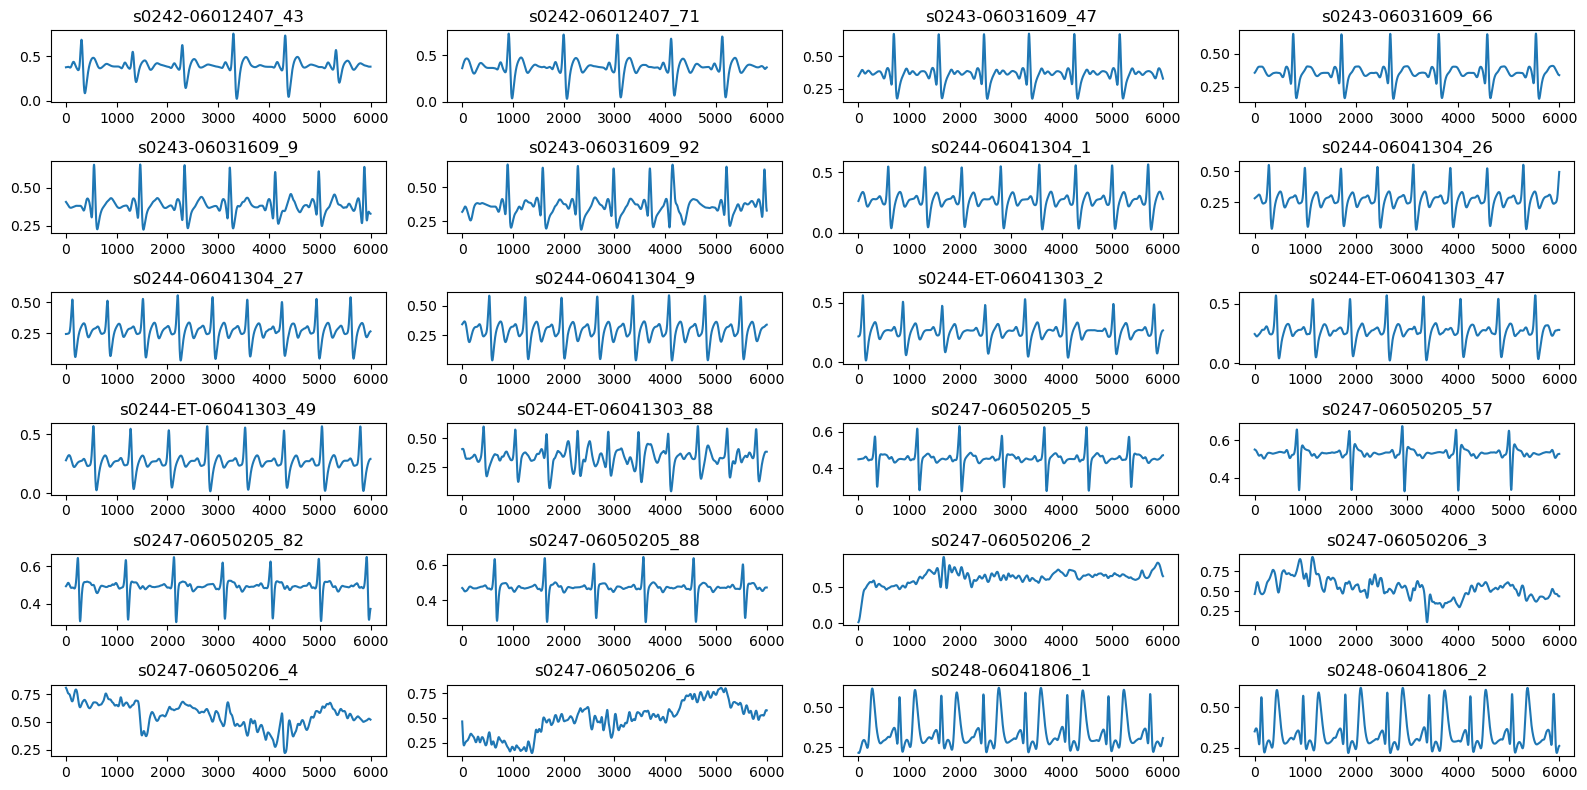

In [208]:

file_names = paging(dataset, 19, 24)

num_plots = len(file_names)
num_cols = 4
num_rows = int(np.ceil(num_plots / num_cols))

fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 8))

for i, file_name in enumerate(file_names):
    print(f'{file_name}_p_signal.txt')
    title = file_name
    file_name = os.path.join(DATASET_QC, f'{file_name}_p_signal.txt')
    
    row = i // num_cols
    col = i % num_cols
    data = np.loadtxt(file_name) 
    data = data[:,0]
    
    axs[row, col].plot(data)
    axs[row, col].set_title(title)  
    
for i in range(num_plots, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

# Check data drawn and call method label manually

In [209]:
label('s0044-05062806_25_p_signal.txt')
label('s0044-05062807_28_p_signal.txt')
label('s0044-05062807_80_p_signal.txt')
label('s0067-05040508_48_p_signal.txt')
label('s0067-05040509_2_p_signal.txt')
label('s0067-05040509_5_p_signal.txt')
label('s0067-05040509_7_p_signal.txt')
label('s0067-05040509_8_p_signal.txt')
label('s0067-05040510_11_p_signal.txt')
label('s0067-05040510_45_p_signal.txt')
label('s0067-05040510_62_p_signal.txt')
label('s0067-05040510_79_p_signal.txt')
label('s0067-05040511_92_p_signal.txt')
label('s0068-05022417_93_p_signal.txt')
label('s0068-05022417_96_p_signal.txt')
label('s0068-05022418_15_p_signal.txt')
label('s0068-05022418_88_p_signal.txt')
label('s0194-05071408_65_p_signal.txt')
label('s0194-05071408_69_p_signal.txt')
label('s0197-05060906_92_p_signal.txt')
label('s0213-05092707_35_p_signal.txt')
label('s0221-06082202_1_p_signal.txt')
label('s0221-06082203_1_p_signal.txt')
label('s0221-06082204_1_p_signal.txt')
label('s0221-06082205_1_p_signal.txt')
label('s0221-06082205_2_p_signal.txt')
label('s0221-06082205_3_p_signal.txt')
label('s0221-06082206_1_p_signal.txt')
label('s0221-06082206_3_p_signal.txt')
label('s0221-06082206_4_p_signal.txt')
label('s0221-06082206_5_p_signal.txt')
label('s0221-06082207_35_p_signal.txt')
label('s0221-06082207_75_p_signal.txt')
label('s0221-06082210_80_p_signal.txt')
label('s0221-06082210_9_p_signal.txt')
label('s0225-06022111_8_p_signal.txt')
label('s0230-06013110_21_p_signal.txt')
label('s0230-06013110_34_p_signal.txt')
label('s0230-06013110_45_p_signal.txt')
label('s0230-06013111_57_p_signal.txt')
label('s0230-06013111_77_p_signal.txt')
label('s0230-06013111_93_p_signal.txt')
label('s0230-06013111_99_p_signal.txt')
label('s0247-06050206_2_p_signal.txt')
label('s0247-06050206_3_p_signal.txt')
label('s0247-06050206_4_p_signal.txt')
label('s0247-06050206_6_p_signal.txt')
label('s0248-06041807_10_p_signal.txt')
label('s0321-07022201_5_p_signal.txt')
label('s0321-07022201_6_p_signal.txt')
label('s0321-07022202_4_p_signal.txt')
label('s0321-07022205_23_p_signal.txt')
label('s0322-07052204_19_p_signal.txt')
label('s0322-07052204_41_p_signal.txt')
label('s0322-07052204_58_p_signal.txt')
label('s0322-07052204_61_p_signal.txt')
label('s0322-07052205_16_p_signal.txt')
label('s0322-07052205_27_p_signal.txt')
label('s0322-07052205_40_p_signal.txt')
label('s0322-07052205_75_p_signal.txt')
label('s0331-07031501_15_p_signal.txt')
label('s0331-07031501_16_p_signal.txt')
label('s0331-07031501_18_p_signal.txt')
label('s0331-07031501_7_p_signal.txt')
label('s0331-07031502_1_p_signal.txt')
label('s0331-07031502_4_p_signal.txt')
label('s0331-07031502_5_p_signal.txt')
label('s0331-07031502_7_p_signal.txt')
label('s0331-07031503_12_p_signal.txt')
label('s0331-07031503_7_p_signal.txt')
label('s0331-07031504_100_p_signal.txt')
label('s0336-07041701_11_p_signal.txt')
label('s0336-07041701_6_p_signal.txt')
label('s0336-07041701_7_p_signal.txt')
label('s0337-07032903_1_p_signal.txt')
label('s0337-07032903_2_p_signal.txt')
label('s0337-07032903_3_p_signal.txt')
label('s0337-07032904_53_p_signal.txt')
label('s0340-07050204_1_p_signal.txt')
label('s0351-07062105_28_p_signal.txt')
label('s0351-07062105_75_p_signal.txt')
label('s0352-07060701_7_p_signal.txt')
label('s0352-07060702_13_p_signal.txt')
label('s0352-07060702_2_p_signal.txt')
label('s0352-07060702_6_p_signal.txt')
label('s0352-07060702_7_p_signal.txt')
label('s0354-07051506_28_p_signal.txt')
label('s0358-07071203_26_p_signal.txt')

label('s0064-05081806_13_p_signal.txt')
label('s0169-04051405_4_p_signal.txt')
label('s0169-04051405_15_p_signal.txt')
label('s0172-05071906_21_p_signal.txt')
label('s0172-05071906_29_p_signal.txt')
label('s0199-05041912_30_p_signal.txt')
label('s0210-05092012_44_p_signal.txt')
label('s0213-05092706_21_p_signal.txt')
label('s0214-05110807_26_p_signal.txt')
label('s0214-05110807_6_p_signal.txt')
label('s0214-05110807_65_p_signal.txt')
label('s0215-06030712_86_p_signal.txt')
label('s0218-05110113_10_p_signal.txt')
label('s0244-ET-06041303_88_p_signal.txt')
label('s0321-07022202_11_p_signal.txt')
label('s0321-07022202_12_p_signal.txt')
label('s0331-07031503_4_p_signal.txt')
label('s0331-07031504_36_p_signal.txt')
label('s0331-07031504_59_p_signal.txt')
label('s0331-07031505_17_p_signal.txt')
label('s0353-07060503_46_p_signal.txt')
label('s0353-07060504_18_p_signal.txt')
label('s0357-07061204_40_p_signal.txt')
label('s0358-07071203_32_p_signal.txt')
label('s0363-07072604_27_p_signal.txt')
label('s0371-07091105_24_p_signal.txt')
label('s0371-07091105_33_p_signal.txt')
label('s0376-07091804_39_p_signal.txt')
label('s0376-07091804_55_p_signal.txt')
label('s0376-07091804_84_p_signal.txt')
label('s0376-07091804_98_p_signal.txt')
label('s0376-07091805_12_p_signal.txt')
label('s0376-07091805_33_p_signal.txt')
label('s0376-07091805_40_p_signal.txt')
label('s0378-07100403_98_p_signal.txt')
label('s0378-07100404_11_p_signal.txt')
label('s0378-07100404_44_p_signal.txt')
label('s0378-07100404_92_p_signal.txt')
label('s0380-07100206_40_p_signal.txt')
label('s0397-08012203_36_p_signal.txt')
label('s0397-08012203_64_p_signal.txt')
label('s0397-08012205_5_p_signal.txt')
label('s0397-08012205_56_p_signal.txt')

# 131 low-quality segments; 666 high-quality segments; 1 label file .txt

In [246]:
def load_data(dataset_path, label_file):
    X = []
    y = []
    with open(os.path.join(dataset_path, label_file), 'r') as file:
        for line in file:
            file_name, label = line.split()
            with open(os.path.join(dataset_path, file_name), 'r') as signal_file:
                signal = np.loadtxt(signal_file)
            X.append(signal)
            y.append(int(label))
    return np.array(X), np.array(y)

X, y = load_data(DATASET_QC, LABEL_FILE)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Filter size kernel
kernel_size = 20
stride = 10
# Size input layer
input_shape = (6000, 5)
# Number of filters
num_filters = 28
# Dropout rate 50% to prevent overfit
dropout_rate = 0.5

model = Sequential([
    Conv1D(filters=num_filters, kernel_size=kernel_size, strides=stride, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(dropout_rate),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])

checkpoint_path = os.path.join(MODEL, "model_checkpoint.keras")
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=30, callbacks=[model_checkpoint])

model.save(os.path.join(MODEL, "qc_model.keras"))

Epoch 1/50
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - binary_accuracy: 0.8316 - loss: 0.5624
Epoch 1: val_loss improved from inf to 0.50020, saving model to model/model_checkpoint.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - binary_accuracy: 0.8311 - loss: 0.5602 - val_binary_accuracy: 0.8594 - val_loss: 0.5002
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.8465 - loss: 0.4707
Epoch 2: val_loss improved from 0.50020 to 0.48033, saving model to model/model_checkpoint.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.8457 - loss: 0.4723 - val_binary_accuracy: 0.8594 - val_loss: 0.4803
Epoch 3/50
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.8312 - loss: 0.4975
Epoch 3: val_loss improved from 0.48033 to 0.46967, saving model to model/model_checkpoint.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - binary_accuracy: 0.8316 - loss: 0.4973 - val_binary_accuracy: 0.8594 - val_loss: 0.4697
Epoch 4/50
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/s

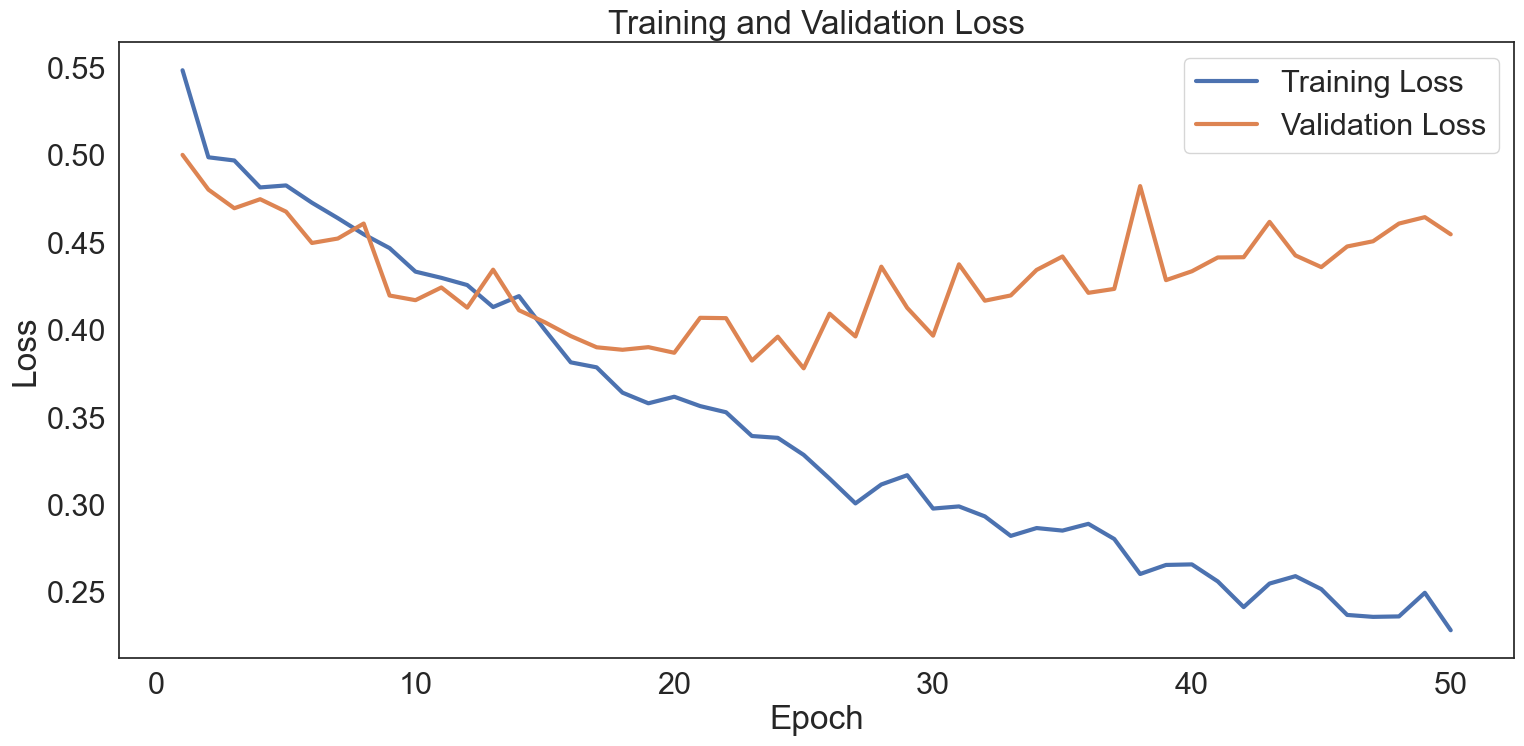

In [248]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(18,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss',linewidth=3.0)
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss',linewidth=3.0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [232]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 599, 28)        │         1,148 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 299, 28)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 299, 28)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8372)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         8,373 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,565 (111.59 KB)

 Trainable params: 9,521 (37.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,044 (74.39 KB)

[0.27391304 0.275      0.27717391 ... 0.36032609 0.35978261 0.35815217] 6000
[0.26161053 0.26231288 0.2630887  ... 0.30548929 0.30631458 0.3070093 ]


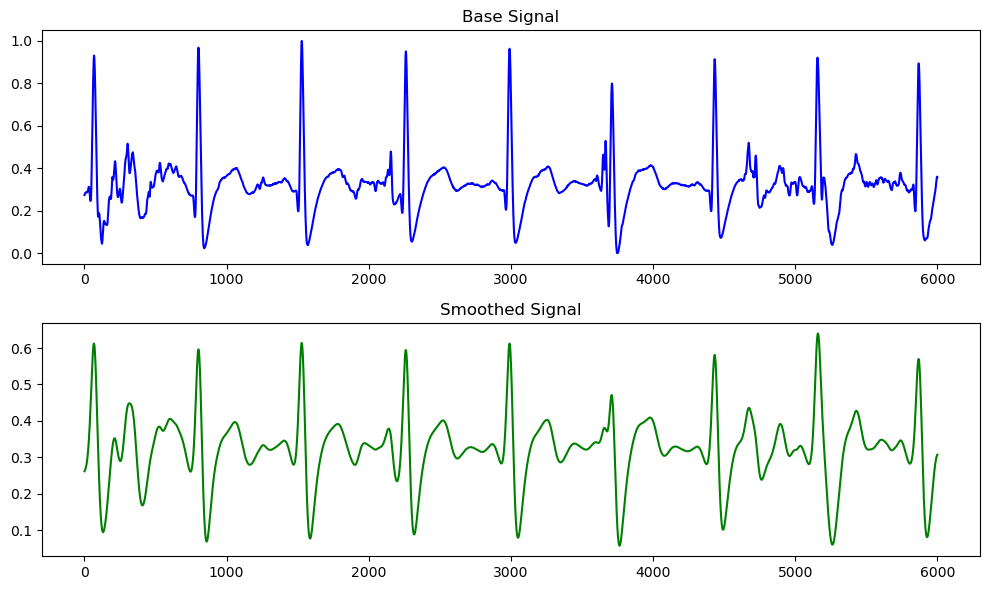

<Figure size 640x480 with 0 Axes>

[0.26161053 0.26231288 0.2630887  ... 0.30548929 0.30631458 0.3070093 ] 6000
[0.26282719 0.26459054 0.26647658 ... 0.27930546 0.27989017 0.28037915]


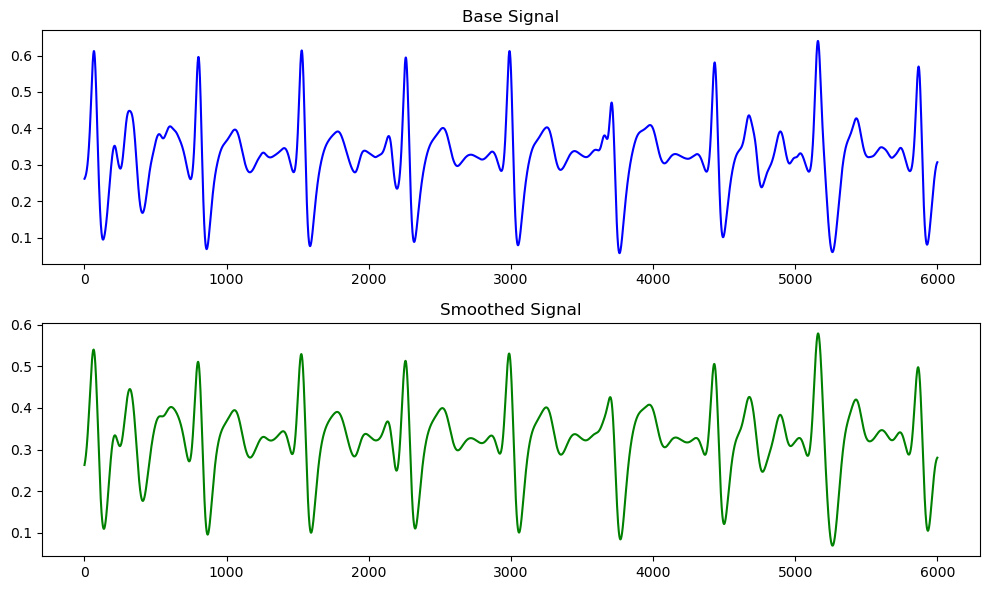

<Figure size 640x480 with 0 Axes>

In [84]:

# Function to apply the low-pass filter
def butterworth_filter(signal):
    cutoff_frequency = 11  # Cutoff frequency in Hz
    sampling_rate = 1000  # Sampling rate in Hz
    order = 2  # Order of the polynomial
    # divide by (0.5 * sampling_rate)
    # frequencies are often normalized by the Nyquist frequency
    # which is half the sampling rate. 
    # The Nyquist frequency is the highest frequency that can be effectively 
    # sampled without introducing aliasing according to the Nyquist-Shannon sampling theorem.
    b, a = butter(order, cutoff_frequency / (0.5 * sampling_rate), btype='low')
    return filtfilt(b, a, signal)

# Get high frequency data after filtering
def hight_freq_sig(signal, smoothed): 
    return signal - smoothed     

# Function to compute derivatives fro smoothed signal
def compute_derivatives(smooth):
    first_derivative = np.gradient(smooth, 10)  # Change in signal for every 10 samples
    second_derivative = np.gradient(first_derivative, 10)
    return first_derivative, second_derivative
  
def pp(signal):
    print(signal, len(signal))
    smooth = butterworth_filter(signal) 
    print(smooth)
    high_freq_data = hight_freq_sig(signal, smooth)       
    first_derivative, second_derivative = compute_derivatives(smooth)
    plt.figure(figsize=(10, 6)) 

    colors = ['blue', 'green', 'red', 'purple', 'orange']

    plt.subplot(2, 1, 1)
    plt.plot(signal, color=colors[0])
    plt.title('Base Signal')

    plt.subplot(2, 1, 2)
    plt.plot(smooth, color=colors[1]) 
    plt.title('Smoothed Signal')

    # plt.subplot(5, 1, 3)
    # plt.plot(high_freq_data, color=colors[2])
    # plt.title('High Freq')

    # plt.subplot(5, 1, 4)
    # plt.plot(first_derivative, color=colors[3])
    # plt.title('1st Derivative')

    # plt.subplot(5, 1, 5)
    # plt.plot(second_derivative, color=colors[4])
    # plt.title('2nd Derivative')

    plt.tight_layout()
    plt.show()

    plt.tight_layout()
    plt.show()

# Get data from 2 column of data for ploting
def extract_columns(file_name, x):
    full_file_path = os.path.join(x, file_name)
    
    data = np.loadtxt(full_file_path)
    
    left = data[:, 0]
    right = data[:, 1]    
    return left, right

def plot(name):
    ss, sss = extract_columns(name, FOLDER_NORMALIZE)
    pp(ss)
    
    ssss, sssss = extract_columns(name, FOLDER_FILTER)
    pp(ssss)
    
    
plot('s0030-04051907_15_p_signal.txt')
# print(smooth, " = ", len(smooth))
# print(high_freq_data, " = ", len(high_freq_data))
# print(first_derivative, " = ", len(first_derivative))
# print(second_derivative, " = ", len(second_derivative))
